<a href="https://colab.research.google.com/github/huntermarchi/6Companies30days/blob/main/hp_power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -------------------------------------------
# 1. IMPORT REQUIRED LIBRARIES
# -------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")


In [3]:
from google.colab import files
uploaded = files.upload()


Saving archive (1).zip to archive (1).zip


In [4]:
import os
os.listdir()


['.config', 'archive (1).zip', 'sample_data']

In [5]:
!unzip "archive (1).zip"


Archive:  archive (1).zip
  inflating: petroleum_prod_consumption.csv  


In [6]:
import os
os.listdir()


['.config', 'petroleum_prod_consumption.csv', 'archive (1).zip', 'sample_data']

In [7]:
import pandas as pd

df_raw = pd.read_csv("petroleum_prod_consumption.csv")
df_raw.head()


,month,year,products,quantity_in_1000_metric_tonnes
0,February,2023,ATF,622.73
1,January,2023,ATF,667.36
2,December,2022,ATF,659.00
3,November,2022,ATF,617.63
4,October,2022,ATF,615.78


In [8]:
df_raw = pd.read_csv("petroleum_prod_consumption.csv")
df_raw.head()


,month,year,products,quantity_in_1000_metric_tonnes
0,February,2023,ATF,622.73
1,January,2023,ATF,667.36
2,December,2022,ATF,659.00
3,November,2022,ATF,617.63
4,October,2022,ATF,615.78


In [9]:
df = df_raw.copy()
df.columns = df.columns.str.lower()
df.head()


,month,year,products,quantity_in_1000_metric_tonnes
0,February,2023,ATF,622.73
1,January,2023,ATF,667.36
2,December,2022,ATF,659.00
3,November,2022,ATF,617.63
4,October,2022,ATF,615.78


In [10]:
df["date"] = pd.to_datetime(df["month"] + " " + df["year"].astype(str))
df = df.sort_values("date")
df.head()


,month,year,products,quantity_in_1000_metric_tonnes,date
209,April,2020,LPG,2113.0,2020-04-01
384,April,2020,Petroleum coke,775.0,2020-04-01
349,April,2020,Others,680.0,2020-04-01
314,April,2020,Naphtha,730.0,2020-04-01
279,April,2020,MS,973.0,2020-04-01


In [11]:
gas_df = df[df["products"].str.contains("gas|cng|lpg", case=False, na=False)]
gas_df.head()


,month,year,products,quantity_in_1000_metric_tonnes,date
209,April,2020,LPG,2113.0,2020-04-01
208,May,2020,LPG,2296.0,2020-05-01
207,June,2020,LPG,2064.0,2020-06-01
206,July,2020,LPG,2258.0,2020-07-01
205,August,2020,LPG,2262.0,2020-08-01


In [12]:
if gas_df.empty:
    print("⚠️ No Natural Gas/CNG data found — generating synthetic gas demand.")

    gas_df = df.copy()
    gas_df["products"] = "Synthetic CNG Demand"

    # Convert quantity into approximate CNG-like values
    gas_df["synthetic_cng"] = gas_df["quantity_in_1000_metric_tonnes"] * np.random.uniform(1.2, 2.5)

    gas_df = gas_df[["date", "synthetic_cng"]]
    gas_df = gas_df.rename(columns={"synthetic_cng": "monthly_demand"})
else:
    gas_df = gas_df.rename(columns={"quantity_in_1000_metric_tonnes": "monthly_demand"})

gas_df.head()


,month,year,products,monthly_demand,date
209,April,2020,LPG,2113.0,2020-04-01
208,May,2020,LPG,2296.0,2020-05-01
207,June,2020,LPG,2064.0,2020-06-01
206,July,2020,LPG,2258.0,2020-07-01
205,August,2020,LPG,2262.0,2020-08-01


In [13]:
gas_df = gas_df.set_index("date")

daily_df = gas_df["monthly_demand"].resample("D").interpolate()
daily_df = daily_df.reset_index()
daily_df.columns = ["date", "demand"]
daily_df.head()


,date,demand
0,2020-04-01,2113.0
1,2020-04-02,2119.1
2,2020-04-03,2125.2
3,2020-04-04,2131.3
4,2020-04-05,2137.4


In [14]:
np.random.seed(42)
days = len(daily_df)

daily_df["traffic_flow"] = np.random.randint(50, 100, days)
daily_df["temperature"] = np.random.randint(18, 40, days)

events = np.zeros(days)
spike_days = np.random.choice(days, 8, replace=False)
events[spike_days] = np.random.randint(100, 300, 8)

daily_df["event_spike"] = events
daily_df["final_demand"] = daily_df["demand"] + events

daily_df.head()


,date,demand,traffic_flow,temperature,event_spike,final_demand
0,2020-04-01,2113.0,88,29,0.0,2113.0
1,2020-04-02,2119.1,78,22,0.0,2119.1
2,2020-04-03,2125.2,64,23,0.0,2125.2
3,2020-04-04,2131.3,92,39,0.0,2131.3
4,2020-04-05,2137.4,57,21,0.0,2137.4


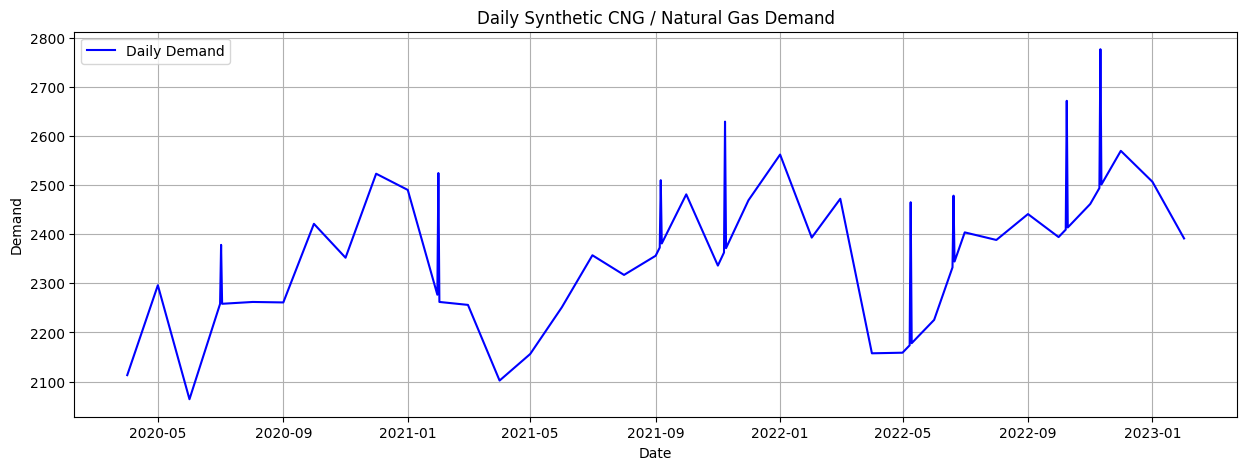

In [15]:
plt.figure(figsize=(15,5))
plt.plot(daily_df["date"], daily_df["final_demand"], label="Daily Demand", color="blue")
plt.title("Daily Synthetic CNG / Natural Gas Demand")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.grid(True)
plt.legend()
plt.show()


In [16]:
ml_df = daily_df.rename(columns={"date": "ds", "final_demand": "y"})
ml_df = ml_df[["ds", "y"]]
ml_df.head()


,ds,y
0,2020-04-01,2113.0
1,2020-04-02,2119.1
2,2020-04-03,2125.2
3,2020-04-04,2131.3
4,2020-04-05,2137.4


In [18]:
!pip install prophet --quiet
!pip install cmdstanpy==1.1.0 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 3.9 MB/s eta 0:00:00


In [20]:
!pip install prophet==1.1.4 --quiet
!pip install cmdstanpy==1.1.0 --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 69.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 77.0 MB/s eta 0:00:00


In [21]:
from prophet import Prophet


In [22]:
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(ml_df)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)


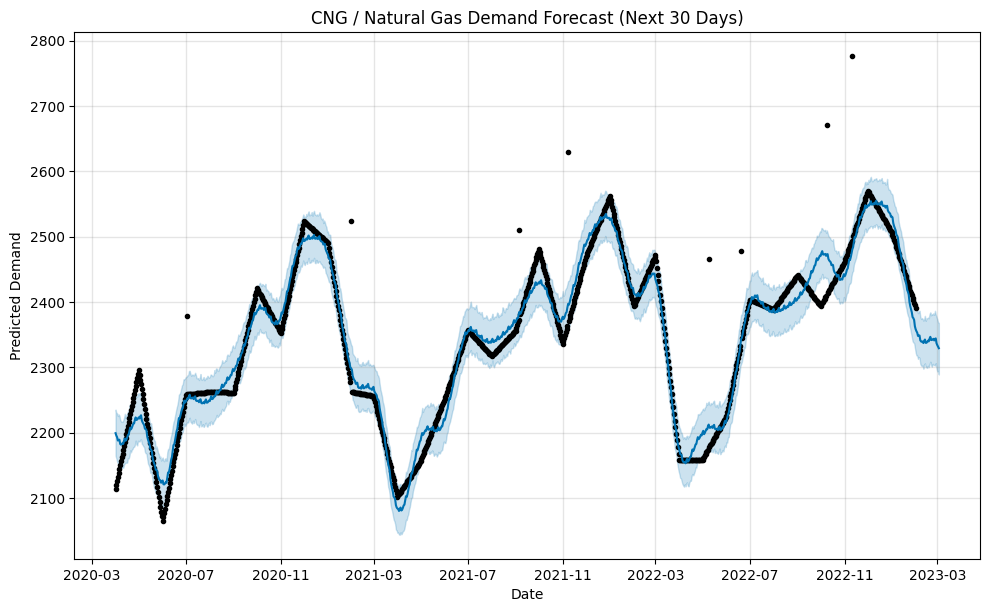

In [23]:
fig = model.plot(forecast)
plt.title("CNG / Natural Gas Demand Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Predicted Demand")
plt.show()


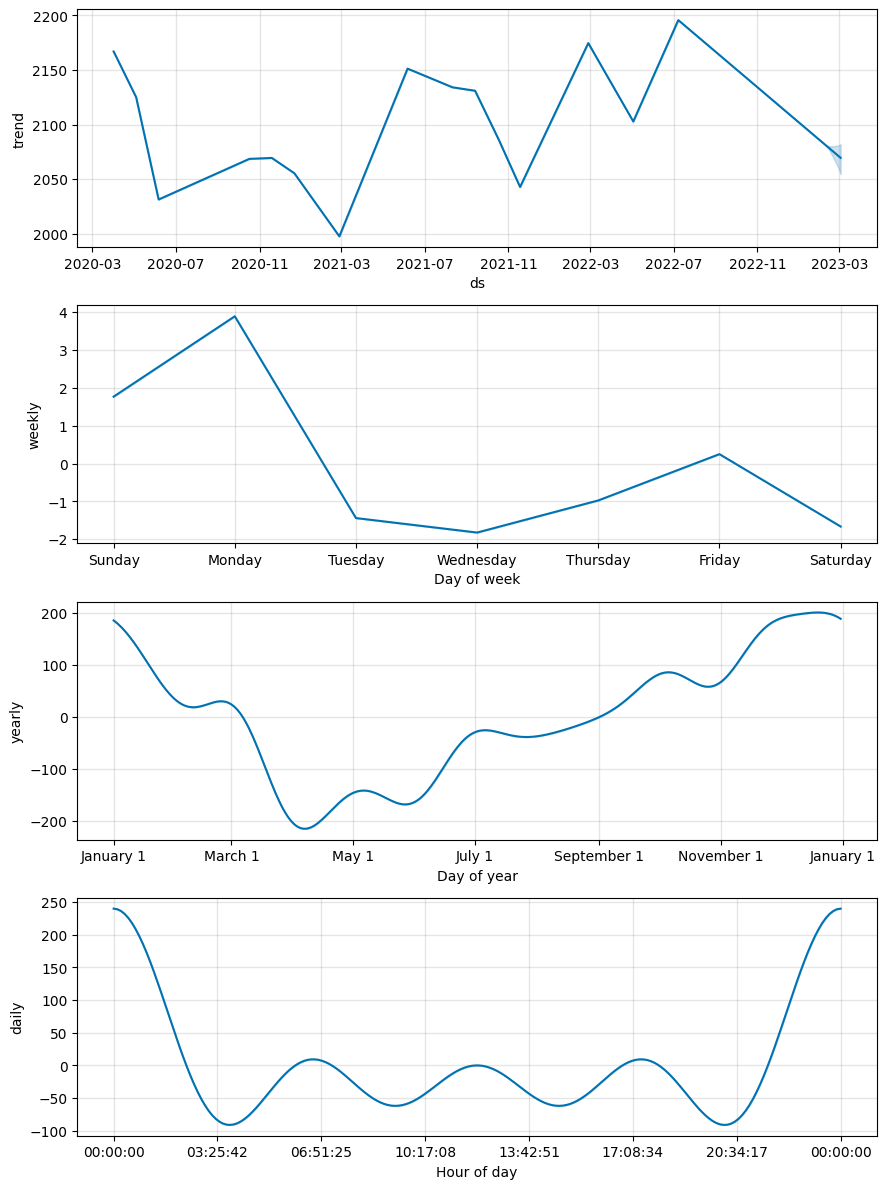

In [24]:
model.plot_components(forecast)
plt.show()
